In [2]:
!pip install opencv-python mediapipe torch torchvision torchaudio numpy matplotlib pandas

In [3]:
# 2. Upload & extract ZIP of videos
from google.colab import files
import zipfile, io, os

uploaded = files.upload()  # Choose your .zip file
for fn, data in uploaded.items():
    if fn.lower().endswith('.zip'):
        z = zipfile.ZipFile(io.BytesIO(data), 'r')
        z.extractall('data')
        z.close()

# List of extracted videos
video_files = sorted(f for f in os.listdir('data') if f.lower().endswith('.mp4'))
print("Detected videos:", video_files)

Saving videos.zip to videos.zip
Detected videos: ['cam_move.mp4', 'dark.mp4', 'face_move.mp4', 'frontal.mp4', 'light.mp4', 'light_face_move.mp4']


In [4]:
# 3. Upload & import your DeepPhysEnhanced class
from google.colab import files

# Upload the .py file containing your class here
uploaded = files.upload()

# Rename it for clean import
for fn in uploaded:
    if fn.lower().endswith('.py'):
        model_file = fn
        break
!mv "{model_file}" DeepPhysEnhanced.py

# Now import the class
from DeepPhysEnhanced import DeepPhysEnhanced
import torch, torch.nn.functional as F

print("DeepPhysEnhanced loaded from:", model_file)

Saving DeepPhysEnhanced.py to DeepPhysEnhanced.py
mv: 'DeepPhysEnhanced.py' and 'DeepPhysEnhanced.py' are the same file
DeepPhysEnhanced loaded from: DeepPhysEnhanced.py


In [5]:
# 4. Preprocessing: face detection + build raw, diff, posgreen inputs and green_avg target
import cv2, mediapipe as mp
import numpy as np
from tqdm import tqdm

# Initialize MediaPipe FaceDetection
mp_fd = mp.solutions.face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.5)

# Containers
X_raw, X_diff, X_posgreen = [], [], []
y_target = []

# Loop through all videos
for vid in video_files:
    cap = cv2.VideoCapture(os.path.join('data', vid))
    success, frame = cap.read()
    prev_face = None
    while success:
        # 1. Detection & crop
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        res = mp_fd.process(rgb)
        h, w, _ = frame.shape
        if res.detections:
            d = res.detections[0].location_data.relative_bounding_box
            x0, y0 = int(d.xmin * w), int(d.ymin * h)
            bw, bh = int(d.width * w), int(d.height * h)
            cx, cy = x0 + bw // 2, y0 + bh // 2
            sz = int(1.6 * max(bw, bh))
            x1, y1 = max(0, cx - sz // 2), max(0, cy - sz // 2)
            x2, y2 = min(w, x1 + sz), min(h, y1 + sz)
            face = frame[y1:y2, x1:x2]
        else:
            face = frame

        # 2. Resize & normalize
        face = cv2.resize(face, (36, 36)).astype(np.float32) / 255.0

        # 3. If we already have a previous frame, compute diff & posgreen
        if prev_face is not None:
            diff = face - prev_face

            # 4. Compute green_avg & pos_avg (simple POS proxy)
            green_avg = float(face[:, :, 1].mean())
            pos_map = face[:, :, 0] * 3 - face[:, :, 1] * 2  # proxy POS channel
            pos_avg = float(pos_map.mean())

            # 5. Build posgreen input (2 constant 36×36 channels)
            ch_g = np.full((36, 36), green_avg, dtype=np.float32)
            ch_p = np.full((36, 36), pos_avg, dtype=np.float32)
            posgreen = np.stack([ch_p, ch_g], axis=2)  # shape (36, 36, 2)

            # 6. Store in lists (in C×H×W for PyTorch)
            X_raw.append(torch.tensor(face).permute(2, 0, 1))
            X_diff.append(torch.tensor(diff).permute(2, 0, 1))
            X_posgreen.append(torch.tensor(posgreen).permute(2, 0, 1))

            y_target.append(green_avg)

        prev_face = face.copy()
        success, frame = cap.read()
    cap.release()

# Convert to tensors
X_raw      = torch.stack(X_raw)        # [N, 3, 36, 36]
X_diff     = torch.stack(X_diff)       # [N, 3, 36, 36]
X_posgreen = torch.stack(X_posgreen)   # [N, 2, 36, 36]
y_target   = torch.tensor(y_target)    # [N]

print("Data ready:", X_raw.shape, X_diff.shape, X_posgreen.shape, y_target.shape)

/usr/local/lib/python3.11/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


Data ready: torch.Size([488, 3, 36, 36]) torch.Size([488, 3, 36, 36]) torch.Size([488, 2, 36, 36]) torch.Size([488])


In [6]:
# 5. Training the DeepPhysEnhanced model
from torch.utils.data import TensorDataset, DataLoader

# Dataset & loader
ds     = TensorDataset(X_diff, X_raw, X_posgreen, y_target)
loader = DataLoader(ds, batch_size=32, shuffle=True)

model     = DeepPhysEnhanced()  # instantiate model
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = torch.nn.MSELoss()

model.train()
for epoch in range(1, 6):
    total_loss = 0
    for d, r, p, y in loader:
        optimizer.zero_grad()
        pred = model(d, r, p).squeeze()
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * d.size(0)
    print(f"Epoch {epoch} — Loss: {total_loss / len(ds):.6f}")

Epoch 1 — Loss: 0.276175
Epoch 2 — Loss: 0.015055
Epoch 3 — Loss: 0.004617
Epoch 4 — Loss: 0.002659
Epoch 5 — Loss: 0.002150


In [9]:
# 6. Inference & BPM Calculation
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

import numpy.fft as fft  # ← required for FFT-based BPM estimation

model.eval()
results = []

for vid in video_files:
    cap = cv2.VideoCapture(os.path.join('data', vid))
    success, frame = cap.read()
    prev_face = None
    preds = []
    fps = cap.get(cv2.CAP_PROP_FPS) or 30  # fallback to 30 if FPS is 0

    while success:
        # --- Detection & cropping same as training ---
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        res = mp_fd.process(rgb)
        h, w, _ = frame.shape
        if res.detections:
            d = res.detections[0].location_data.relative_bounding_box
            x0, y0 = int(d.xmin * w), int(d.ymin * h)
            bw, bh = int(d.width * w), int(d.height * h)
            cx, cy = x0 + bw // 2, y0 + bh // 2
            sz = int(1.6 * max(bw, bh))
            x1, y1 = max(0, cx - sz // 2), max(0, cy - sz // 2)
            x2, y2 = min(w, x1 + sz), min(h, y1 + sz)
            face = frame[y1:y2, x1:x2]
        else:
            face = frame

        # Resize & normalize to float32
        face = cv2.resize(face, (36, 36)).astype(np.float32) / 255.0

        if prev_face is not None:
            diff = face - prev_face

            # Calculate green and pos_val
            green = float(face[:, :, 1].mean())
            pos_map = face[:, :, 0] * 3 - face[:, :, 1] * 2
            pos_val = float(pos_map.mean())

            # Construct input tensors
            t_r = torch.tensor(face, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
            t_d = torch.tensor(diff, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)
            pg = np.stack([
                np.full((36, 36), pos_val, dtype=np.float32),
                np.full((36, 36), green,   dtype=np.float32)
            ], axis=2)
            t_p = torch.tensor(pg, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

            # Predict
            with torch.no_grad():
                pred = model(t_d, t_r, t_p).item()
            preds.append(pred)

        prev_face = face.copy()
        success, frame = cap.read()

    cap.release()

    # BPM via FFT
    if len(preds) == 0:
        bpm = 0.0
    else:
        s = np.array(preds) - np.mean(preds)
        N = len(s)
        freqs = fft.rfftfreq(N, 1.0 / fps)
        P = np.abs(fft.rfft(s))
        mask = (freqs >= 0.7) & (freqs <= 4.0)
        if mask.any():
            f0 = freqs[mask][P[mask].argmax()]
            bpm = f0 * 60.0
        else:
            bpm = 0.0

    print(f"{vid} → {bpm:.1f} BPM")
    results.append((vid, bpm, np.array(preds)))


cam_move.mp4 → 71.1 BPM
dark.mp4 → 94.8 BPM
face_move.mp4 → 87.5 BPM
frontal.mp4 → 54.5 BPM
light.mp4 → 49.8 BPM
light_face_move.mp4 → 78.3 BPM


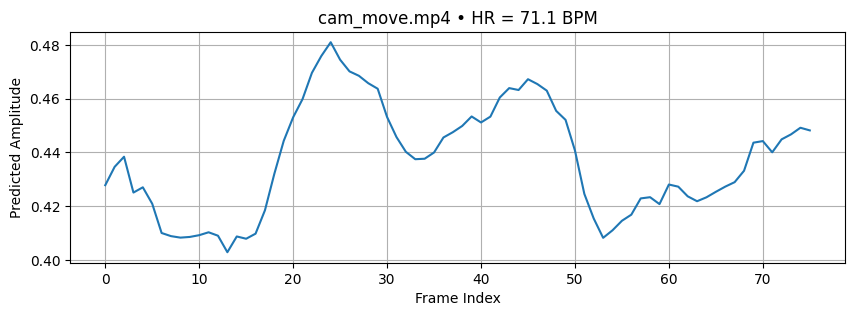

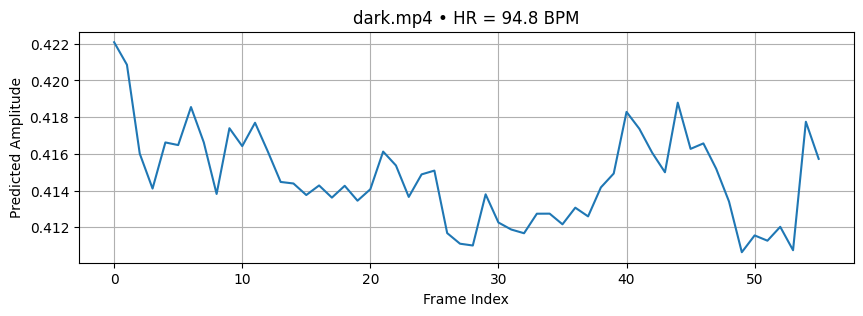

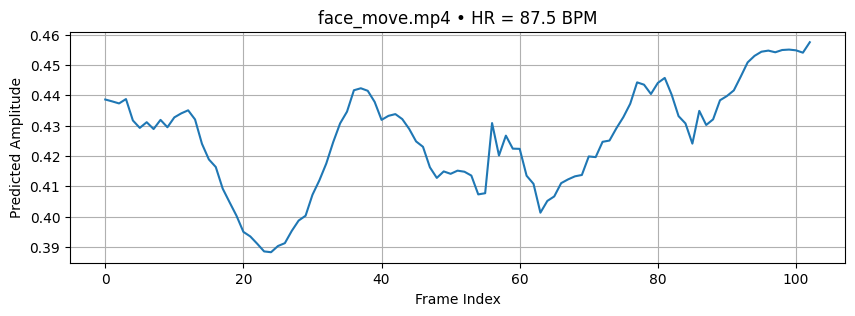

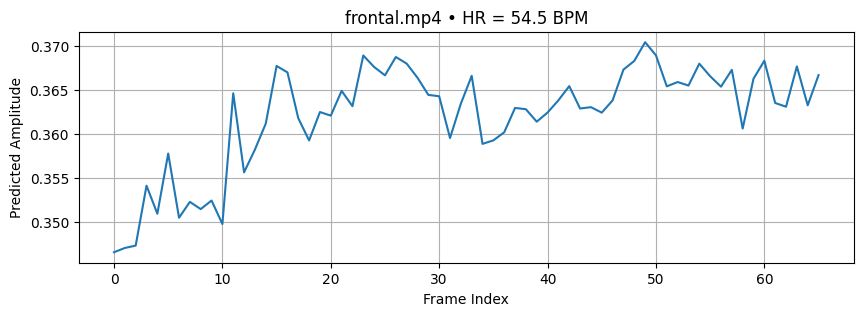

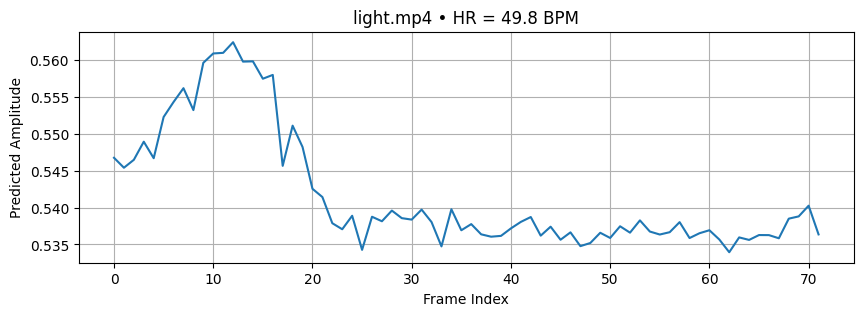

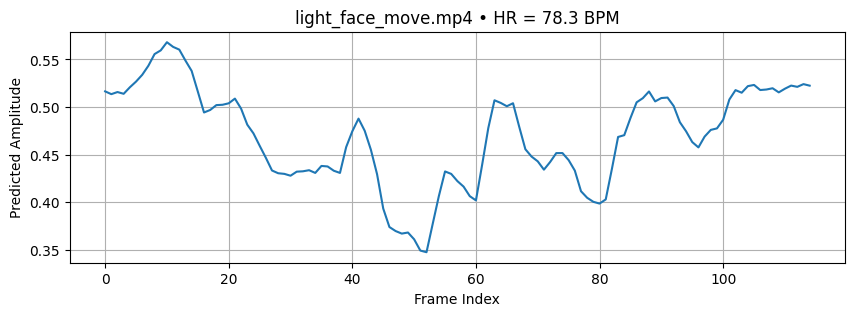

In [12]:
# 7. Visualization of Estimated Signals
import matplotlib.pyplot as plt

for vid, bpm, sig in results:
    if sig.size == 0:
        continue
    plt.figure(figsize=(10, 3))
    plt.plot(sig)
    plt.title(f"{vid} • HR = {bpm:.1f} BPM")
    plt.xlabel("Frame Index")
    plt.ylabel("Predicted Amplitude")
    plt.grid(True)
    plt.show()


In [11]:
# 8. Compile results into a DataFrame and save BPMs to CSV
import pandas as pd
import csv

df = pd.DataFrame([
    {"video_name": v, "estimated_bpm": b, "predicted_signal": s}
    for v, b, s in results
])

# Save BPMs to a CSV file
bpm_results = [(v, b) for v, b, _ in results]
with open("bpm_results.csv", "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Video", "Estimated_BPM"])
    writer.writerows(bpm_results)

print("\n✅ All BPMs have been saved to bpm_results.csv")
df



✅ All BPMs have been saved to bpm_results.csv


,video_name,estimated_bpm,predicted_signal
0,cam_move.mp4,71.115743,"[0.42778873443603516, 0.4346177577972412, 0.43..."
1,dark.mp4,94.844502,"[0.4220823645591736, 0.4208545684814453, 0.416..."
2,face_move.mp4,87.455445,"[0.4385993480682373, 0.43797677755355835, 0.43..."
3,frontal.mp4,54.545726,"[0.3466166853904724, 0.34709733724594116, 0.34..."
4,light.mp4,49.837743,"[0.5467575788497925, 0.5454074740409851, 0.546..."
5,light_face_move.mp4,78.330647,"[0.5164608359336853, 0.5135279893875122, 0.515..."
